In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from ipywidgets import interact
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


In [21]:
import pandas as pd

# List of raw paths to your CSV files
csv_files = [
    r'C:\Users\Nirranjana\OneDrive\Desktop\rainfall.csv',
    r'C:\Users\Nirranjana\OneDrive\Desktop\Karur.csv',
    r'C:\Users\Nirranjana\OneDrive\Desktop\Dindigul.csv',
]

data = pd.DataFrame()
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file, encoding='ISO-8859-1')
        data = pd.concat([data, df], ignore_index=True)
    except UnicodeDecodeError:
        print(f"Could not read file {csv_file} with ISO-8859-1 encoding.")
        

# Check for missing values (NaN) in the concatenated dataframe
missing_values = data.isnull().sum()
print(missing_values)

Station Code             0
Station Name             0
District                 0
Latitude                 0
Longitude                0
Year                     0
Month                    0
Day                      0
Hour                     0
Min Temperature      20135
Max Temperature      13368
Temp Dry Bulb          296
Temp Wet Bulb          808
Relative Humidity     8168
Inst Wind Speed      32012
Av Wind Speed        39147
Wind direction        1739
Pan Evaporation       3512
Rainfall               746
dtype: int64


In [22]:
data['Hour'] = pd.to_datetime(data['Hour'], format='%H:%M', errors='coerce', exact=False)
data['Hour_Hour'] = data['Hour'].dt.minute
data['Hour_Minute'] = data['Hour'].dt.hour
years = data['Year'].unique()
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999], dtype=int64)

In [23]:
months = data['Month'].unique()
months

array([ 1,  2,  3,  4,  5,  7,  8,  9, 11,  6, 10, 12], dtype=int64)

In [24]:
#seasonal filling for nulls
def seasonal_fill(column):
  c = 0
  yearly = []
  for year in years :
    monthly = []
    for month in range(1,13):
      selected_rows = data[(data['Year'] == year) & (data['Month'] == month)]
      monthly_avg = selected_rows[column].mean()
      data.loc[(data['Year'] == year) & (data['Month'] == month), column] = monthly_avg
      monthly.append(monthly_avg)
    yearly.append(monthly)
  means = []
  for i in range(len(yearly[0])):
    values = []
    for j in range(len(yearly)):
      values.append(yearly[j][i])
    mean = np.nanmean(values)
    means.append(mean)
  print(means)
  for val in range(len(means)):
    data.loc[(data['Month'] == val+1) & (data[column].isna()|data[column].isnull()), column] = means[val]


seasonal_fill('Temp Dry Bulb')
seasonal_fill('Temp Wet Bulb')
seasonal_fill('Relative Humidity')
seasonal_fill('Inst Wind Speed')
seasonal_fill('Av Wind Speed')
seasonal_fill('Pan Evaporation')

[26.415628790870592, 28.249930377752648, 30.5865550109945, 31.944433387725805, 31.56752578702254, 30.252099487602738, 29.674343367767815, 29.47744898948026, 29.340222287849826, 28.222819480069365, 26.86062665404519, 26.033781640727273]
[21.768292785063597, 22.33336453118651, 23.642931090677987, 25.152788552347527, 25.348997162485066, 24.650042606993015, 24.22060020011534, 24.209331046817677, 24.295651822137877, 24.349024499077377, 23.65353439826871, 22.420855765250547]
[65.81349319896812, 59.311984163031475, 55.62264070558077, 57.02449392693182, 59.42875267790724, 60.93074526576609, 61.67295432862396, 62.7750910903553, 64.32629477552318, 71.97820545304543, 75.45235578672379, 72.3408411998231]
[2.7060875024544413, 3.7349923660082007, 4.227859880229524, 3.9980901142334235, 5.5461648667477474, 8.230098976066294, 9.853935817369758, 8.055723845501157, 5.448242612945507, 3.0024898996722005, 2.0194248335371134, 2.318167157402392]
[3.120255614580511, 3.3665785944663416, 3.477817308900871, 3.90

In [25]:
data.isnull().sum()

Station Code             0
Station Name             0
District                 0
Latitude                 0
Longitude                0
Year                     0
Month                    0
Day                      0
Hour                     0
Min Temperature      20135
Max Temperature      13368
Temp Dry Bulb            0
Temp Wet Bulb            0
Relative Humidity        0
Inst Wind Speed          0
Av Wind Speed            0
Wind direction        1739
Pan Evaporation          0
Rainfall               746
Hour_Hour                0
Hour_Minute              0
dtype: int64

In [26]:
#padding
columns_to_fill = ['Min Temperature', 'Max Temperature','Rainfall']
data[columns_to_fill] = data[columns_to_fill].fillna(method='ffill')

In [27]:
#one hot encoding categorical values
data['Wind direction'].unique()
data_encoded = pd.get_dummies(data, columns=['Wind direction'], prefix='Wind_direction')
print(data_encoded)

       Station Code                    Station Name  District    Latitude   
0       BAVANISAGAR  Bhavanisagar FCS                   Erode   11°28'24"  \
1       BAVANISAGAR  Bhavanisagar FCS                   Erode   11°28'24"   
2       BAVANISAGAR  Bhavanisagar FCS                   Erode   11°28'24"   
3       BAVANISAGAR  Bhavanisagar FCS                   Erode   11°28'24"   
4       BAVANISAGAR  Bhavanisagar FCS                   Erode   11°28'24"   
...             ...                             ...       ...         ...   
121713  VIRALIPATTI  Viralipatti                     Dindigul  10Â°07'33"   
121714  VIRALIPATTI  Viralipatti                     Dindigul  10Â°07'33"   
121715  VIRALIPATTI  Viralipatti                     Dindigul  10Â°07'33"   
121716  VIRALIPATTI  Viralipatti                     Dindigul  10Â°07'33"   
121717  VIRALIPATTI  Viralipatti                     Dindigul  10Â°07'33"   

         Longitude  Year  Month  Day                Hour  Min Temperature  

In [28]:
data.isnull().sum()

Station Code            0
Station Name            0
District                0
Latitude                0
Longitude               0
Year                    0
Month                   0
Day                     0
Hour                    0
Min Temperature         0
Max Temperature         0
Temp Dry Bulb           0
Temp Wet Bulb           0
Relative Humidity       0
Inst Wind Speed         0
Av Wind Speed           0
Wind direction       1739
Pan Evaporation         0
Rainfall                0
Hour_Hour               0
Hour_Minute             0
dtype: int64

In [29]:
mae_l = []
mse_l = []
rmse_l = []
r2_l = []
def Metrics(ytest, ypred):
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    rmse = mse ** 0.5
    r2 = r2_score(ytest, ypred)
    mae_l.append(mae)
    mse_l.append(mse)
    rmse_l.append(rmse)
    r2_l.append(r2)
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-Squared: ", r2)

In [30]:
X = data[[
    "Year",
    "Month",
    "Day",
    "Hour_Hour",
    "Hour_Minute",
    "Rainfall",
    "Min Temperature",
    "Max Temperature",
    "Temp Dry Bulb",
    "Temp Wet Bulb",
    "Relative Humidity",
    "Inst Wind Speed",
    "Av Wind Speed",
    "Pan Evaporation"]]
y = data['Rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
#GradientBOOST

import time
start_time = time.time()

gb_regressor = GradientBoostingRegressor(n_estimators=110, random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred = gb_regressor.predict(X_test)

Metrics(y_test,y_pred)
end_time = time.time()
elapsed_time_gb = end_time - start_time
print(f"Model took {elapsed_time_gb} seconds to run.")

MAE:  0.007446151999397402
MSE:  0.0018602818618860867
RMSE:  0.04313098493990239
R-Squared:  0.9999370134101535
Model took 17.210383892059326 seconds to run.


In [32]:
#random forest
import time

start_time = time.time()


rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

Metrics(y_test,y_pred)
end_time = time.time()
elapsed_time_rf = end_time - start_time
print(f"Model took {elapsed_time_rf} seconds to run.")


MAE:  0.0009125753094536218
MSE:  0.0005653078201336421
RMSE:  0.023776202811501296
R-Squared:  0.9999808594533263
Model took 32.744951486587524 seconds to run.


In [38]:
#knn

import time

start_time = time.time()
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

Metrics(y_test,y_pred)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Model took {elapsed_time_knn} seconds to run.")

MAE:  0.14207295432139336
MSE:  0.2720883785737759
RMSE:  0.5216209146245728
R-Squared:  0.9904729259283064
Model took 7.824233770370483 seconds to run.


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).

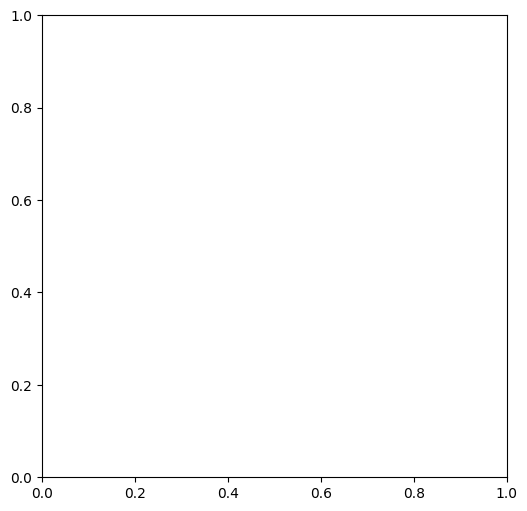

In [43]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ["GradientBoost", "Random Forest", "KNN"]

fig, ax = plt.subplots(figsize=(6, 6))
bar_width = 0.2
index = np.arange(len(model_names))

ax.bar(index - bar_width, mae_l, bar_width, color='salmon', label='MAE')
ax.bar(index, mse_l, bar_width, color='red', label='MSE')
ax.bar(index + bar_width, r2_l, bar_width, color='lightblue', label='R2')

ax.set_xlabel("Models")
ax.set_title("MAE, MSE and R2 for Different Models")
ax.set_xticks(index)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

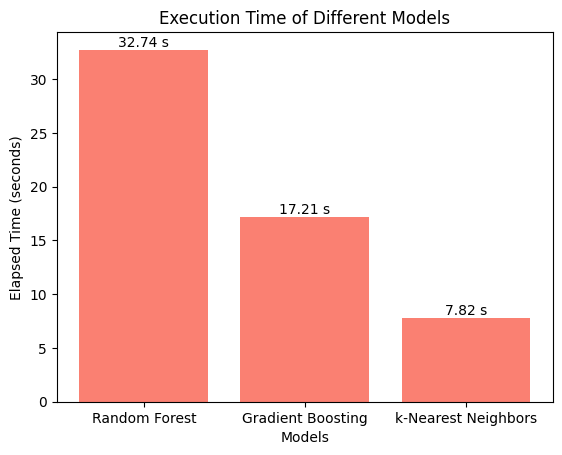

In [44]:
import matplotlib.pyplot as plt

# Names of the models
models = ['Random Forest', 'Gradient Boosting', 'k-Nearest Neighbors']

# Corresponding elapsed times
elapsed_times = [elapsed_time_rf, elapsed_time_gb, elapsed_time_knn]

# Create a bar chart
plt.bar(models, elapsed_times, color='salmon')

# Label the axes
plt.xlabel('Models')
plt.ylabel('Elapsed Time (seconds)')

# Set the title
plt.title('Execution Time of Different Models')
for i, v in enumerate(elapsed_times):
    plt.text(i, v, f'{v:.2f} s', ha='center', va='bottom')

# Show the plot
plt.show()
